# Build a Generative Adversarial Network (GAN) for generating fake images using PyTorch and MNIST

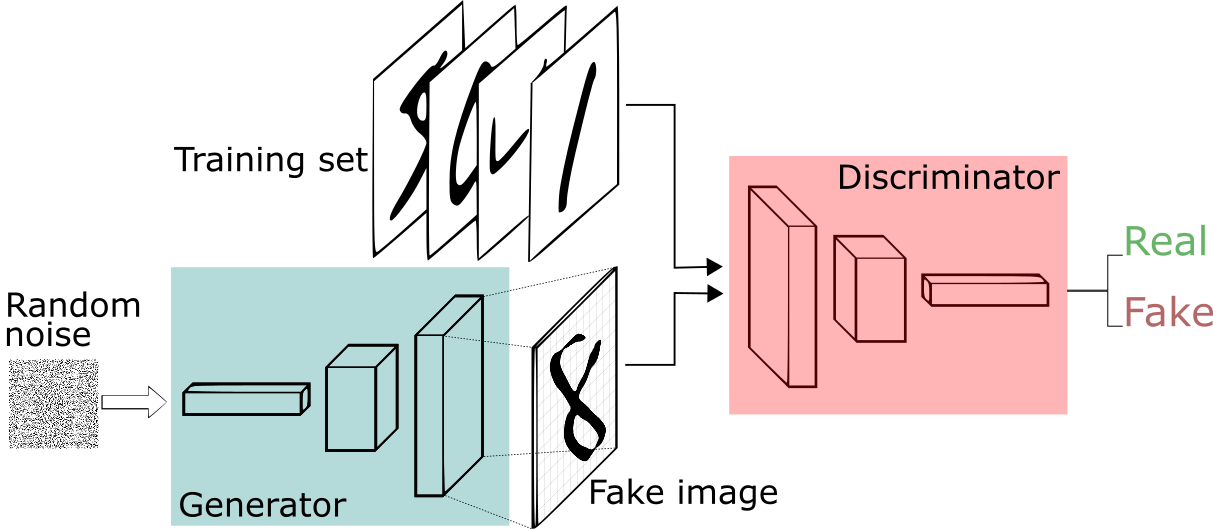

In [77]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurations

In [78]:
device = 'cuda' # this will be used to transfer images to GPU device : image = image.to(device)
# device = 'cpu' # this will be used to transfer images to GPU device : image = image.to(device)
batch_size = 128
noise_dim = 64

# optimizers patameters
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 50


# Load MNIST Dataset

In [79]:
from torchvision import datasets, transforms as T

In [80]:
train_augs = T.Compose([
    T.RandomRotation((-20, +20)),
    T.ToTensor() # (h, w, c) -> (c, h, w)  # changing the images to torch tensors
])

In [81]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

trainset = datasets.MNIST('MNIST', download = True, train = True, transform = train_augs)

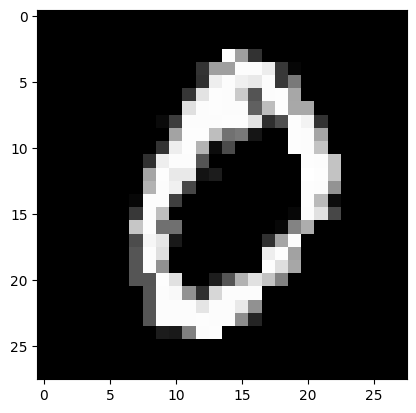

In [82]:
image, label = trainset[1]
plt.imshow(image.squeeze(), cmap = 'gray')

In [83]:
print("total images present in trainset are: ", len(trainset))

total images present in trainset are:  60000


# Load Dataset Into Batches

In [84]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [85]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle = True)
print("total number of batches in tarinloader: ", len(trainloader))

total number of batches in tarinloader:  469


In [86]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [87]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

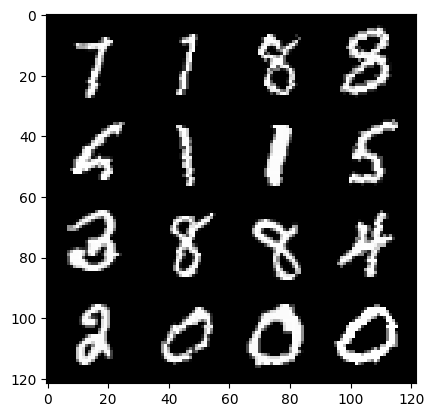

In [88]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

Discriminator Network is a simple binary classifier which classifies whether a given image is real or fake.

In [89]:
#In case if torch summary is not installed

!pip install torchsummary

In [90]:
from torch import nn
from torchsummary import summary

In [91]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

In [92]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [93]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features = 64, out_features = 1)

    def forward(self, images):
        x1 = self.block_1(images)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)

        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [94]:
D = Discriminator()
D.to(device)
summary(D, input_size= (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [95]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [96]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [97]:
class Generator(nn.Module):

    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block_2 = get_gen_block(256, 128, (4,4), 1)
        self.block_3 = get_gen_block(128, 64, (3,3), 2)

        self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

    def forward(self, r_noise_vec):

        #(bs, noise_dim) -> (bs, noise_dim, 1, 1)
        x = r_noise_vec.view(-1, self.noise_dim, 1, 1)

        x1 = self.block_1(x)
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        x4 = self.block_4(x3)
        return x4


In [98]:
G = Generator(noise_dim)
G.to(device)
summary(G, input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [99]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [100]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [101]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss
def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [102]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas=(beta_1, beta_2))

# Training Loop























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:11<00:00,  2.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9620961..0.9976887].


Epoch: 1 | D_loss: 0.6837485769410123 | G_loss: 0.6925308380299794


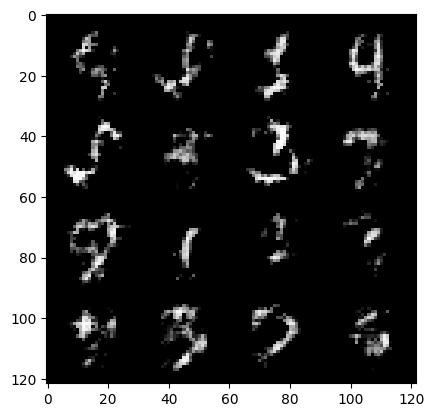























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:04<00:00,  2.55it/s]


Epoch: 2 | D_loss: 0.6778060274083477 | G_loss: 0.7114013221218134
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:03<00:00,  2.56it/s]


Epoch: 3 | D_loss: 0.6442842892746428 | G_loss: 0.7478045420860177
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


Epoch: 4 | D_loss: 0.6225279146420167 | G_loss: 0.7744456178852236
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:04<00:00,  2.54it/s]


Epoch: 5 | D_loss: 0.6230364467289402 | G_loss: 0.7832655225481305
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 6 | D_loss: 0.6303688447866866 | G_loss: 0.7852421601189733
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:00<00:00,  2.60it/s]


Epoch: 7 | D_loss: 0.6327120950227099 | G_loss: 0.7892797810436566
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 8 | D_loss: 0.6341244096694979 | G_loss: 0.7944094551397539
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 9 | D_loss: 0.6369494062496909 | G_loss: 0.7988224855618182
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


Epoch: 10 | D_loss: 0.6406178310481724 | G_loss: 0.7943863359087312
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 11 | D_loss: 0.645214407174572 | G_loss: 0.7891560251524707
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 12 | D_loss: 0.6507629693698272 | G_loss: 0.7852262408494441
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 13 | D_loss: 0.6531531153711428 | G_loss: 0.7814951217504961
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:00<00:00,  2.60it/s]


Epoch: 14 | D_loss: 0.6550518883062578 | G_loss: 0.7792894650878174
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


Epoch: 15 | D_loss: 0.6559045992172094 | G_loss: 0.7789917833515322
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:00<00:00,  2.59it/s]


Epoch: 16 | D_loss: 0.6561200260353495 | G_loss: 0.7791896504379793
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 17 | D_loss: 0.657809509778582 | G_loss: 0.7757472971609152
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 18 | D_loss: 0.6588471618288362 | G_loss: 0.776150283910064
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 19 | D_loss: 0.6611502405677014 | G_loss: 0.7745623291174232
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 20 | D_loss: 0.6613344783976134 | G_loss: 0.7736291216888915
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 21 | D_loss: 0.6619299046520485 | G_loss: 0.7728731547083173
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 22 | D_loss: 0.6612506323277569 | G_loss: 0.7736834714661783
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 23 | D_loss: 0.661231878978103 | G_loss: 0.7715056800384765
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 24 | D_loss: 0.661184116975585 | G_loss: 0.7721997515987485
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 25 | D_loss: 0.6611710504682333 | G_loss: 0.7761703627958481
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2890623..1.0].


Epoch: 26 | D_loss: 0.6605594264927195 | G_loss: 0.7752322409707092


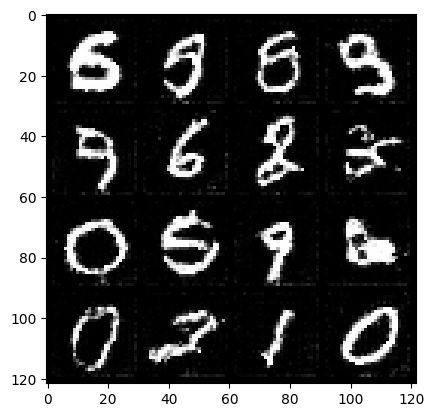























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 27 | D_loss: 0.6604074703604936 | G_loss: 0.775621644215289
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 28 | D_loss: 0.6604251055829307 | G_loss: 0.7788915217304027
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 29 | D_loss: 0.659197447269456 | G_loss: 0.7776456885754681
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.59it/s]


Epoch: 30 | D_loss: 0.6595008872719462 | G_loss: 0.7811741174411163
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 31 | D_loss: 0.6573505354588474 | G_loss: 0.7833606769789511
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 32 | D_loss: 0.6565352907058781 | G_loss: 0.7868381531507984
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 33 | D_loss: 0.6554705998790797 | G_loss: 0.7882174780882244
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:03<00:00,  2.55it/s]


Epoch: 34 | D_loss: 0.654748451735165 | G_loss: 0.7907165380429103
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 35 | D_loss: 0.6536220289242547 | G_loss: 0.7922773807287724
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 36 | D_loss: 0.6562617032258495 | G_loss: 0.7915896714877472
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 37 | D_loss: 0.6545571193003705 | G_loss: 0.7951763569673241
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 38 | D_loss: 0.6533838607100789 | G_loss: 0.7950467830781998
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 39 | D_loss: 0.6537903036390033 | G_loss: 0.7965327839353191
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.58it/s]


Epoch: 40 | D_loss: 0.6526313237289885 | G_loss: 0.7996245020234001
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 41 | D_loss: 0.6522585703874193 | G_loss: 0.7973375310267466
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 42 | D_loss: 0.6539430966509431 | G_loss: 0.7985108679037358
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:03<00:00,  2.56it/s]


Epoch: 43 | D_loss: 0.6533212169909528 | G_loss: 0.802483620038673
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


Epoch: 44 | D_loss: 0.6506288075752096 | G_loss: 0.8047029930137114
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.58it/s]


Epoch: 45 | D_loss: 0.64906249371673 | G_loss: 0.807646667525204
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


Epoch: 46 | D_loss: 0.648511641696572 | G_loss: 0.8097216840237697
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 47 | D_loss: 0.6491365788587883 | G_loss: 0.8078754348541374
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.57it/s]


Epoch: 48 | D_loss: 0.6470919473847346 | G_loss: 0.8117042783735149
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:01<00:00,  2.58it/s]


Epoch: 49 | D_loss: 0.6472761791143844 | G_loss: 0.8166320744608002
























































































































































































































































































































































































































































































100%|██████████| 469/469 [03:02<00:00,  2.58it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25451916..1.0].


Epoch: 50 | D_loss: 0.6458049316141905 | G_loss: 0.8170950311079208


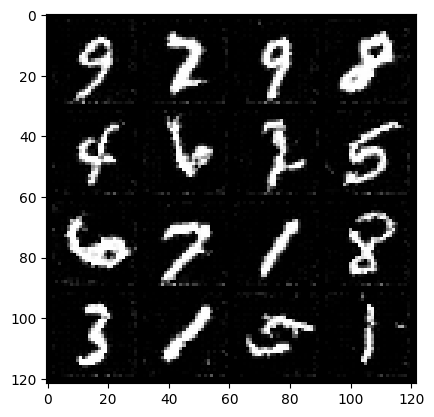

In [103]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim, device = device)

        # find loss and update weights for D

        D_opt.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss) / 2
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_opt.step()

        # find loss and update weights for G

        G_opt.zero_grad()

        noise = torch.randn(batch_size, noise_dim, device = device)

        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        G_loss.backward()
        G_opt.step()

    avg_d_loss = total_d_loss / len(trainloader)
    avg_g_loss = total_g_loss / len(trainloader)

    print("Epoch: {} | D_loss: {} | G_loss: {}".format(i+1, avg_d_loss, avg_g_loss))

    if (i==0 or i==round(epochs/2) or i==epochs-1):
        show_tensor_images(fake_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4220422..1.0].


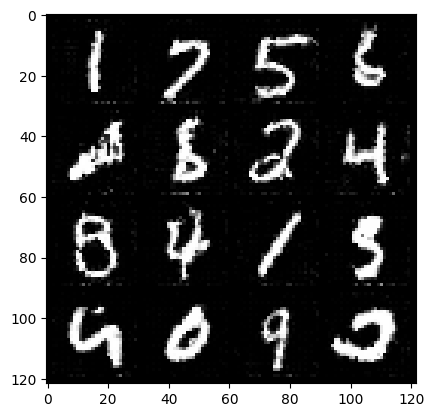

In [104]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29338384..1.0].


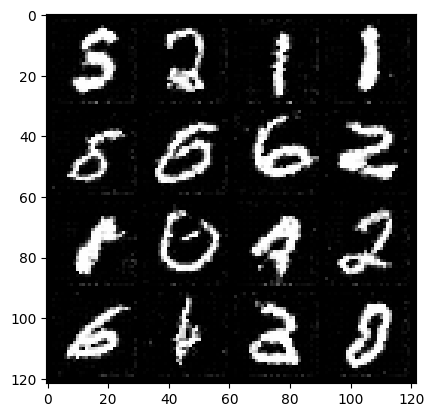

In [105]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)